# Matplotlib tutorial, and the kernel trick

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # needed for 3d plotting
import pandas as pd
from sklearn.linear_model import LinearRegression

%matplotlib inline

def add_noise(y, intensity = 1.0):
    """ Add noise to a vector."""
    return y + intensity*np.random.randn(y.shape[0])

# Matplotlib's objects: for when you need them 

When you create a plot in matplotlib, you're really defining a `Figure` object and an `AxesSubfigure`.  If you don't have a line of code doing that explicitly, then matplotlib is doing it under the hood.  Most calls to `plt.foo` are really helper methods that are calling the method `foo` of the most recent `Figure` or `AxesSubfigure` object.  Let's see what that means. 

In [8]:
# An explicit graph using the object-oriented language.  First we create data
x = np.arange(0,100,.1)
y = np.random.randn(1000).cumsum()

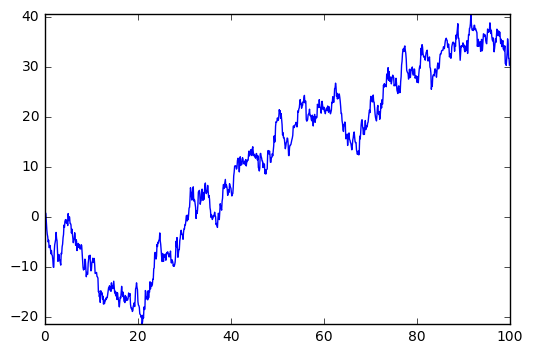

In [9]:
# Create a Figure object in which my plot will reside
fig = plt.figure()

# Create a subplot within that.  The first two 1's correspond to the dimensions 
# of my subplots (here, 1 horiz and 1 vertical), and the last one is the first
# of the plots (*grumble grumble zero indexing...*)
ax = fig.add_subplot(1,1,1)

# Now use all your normal graphing commands on ax
ax.plot(x,y, 'b-')
ax.axis([0,100,y.min(),y.max()])

plt.show()

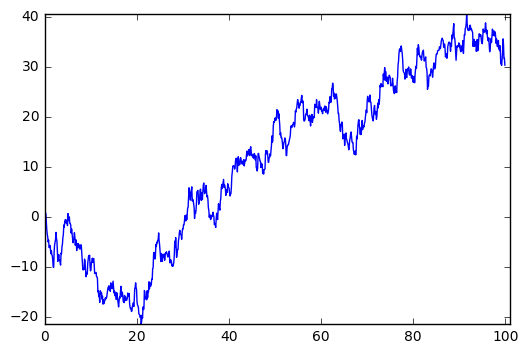

In [10]:
# Alternatively, you can just use the commands you're familiar with, 
# and it will create the objects for you:
plt.plot(x,y, 'b-')
plt.axis([0,101,y.min(),y.max()])

plt.show()

# Side note: if you run this cell and nothing happened, that's because 
# you are already in %matplotlib notebook mode!  Try changing the color
# to red to see what's happening (hint, look up)

In order to graph actual subplots, we would simply define more of them.

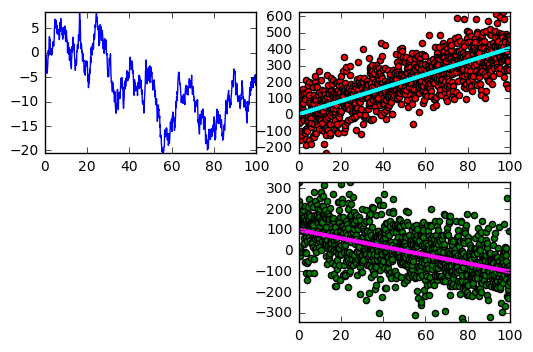

In [11]:
# First we create data
x = np.arange(0,100,.1)
lines = [{'b':2,'m':4}, {'b':100,'m':-2}]
y = [add_noise(np.array([lines[line]['b'] + i * lines[line]['m'] for i in x]), intensity=100) for line in range(len(lines))]
y_tl = np.random.randn(1000).cumsum()

# Create a Figure object in which my plot will reside
fig = plt.figure()

# Create subplots within that.  The first two 2's are creating the 2x2 array, 
# the third is the index of the subplot. 
topleft = fig.add_subplot(2,2,1)
topright = fig.add_subplot(2,2,2)
bottomright = fig.add_subplot(2,2,4)

# Perform each subplot separately 
topleft.axis([0,100,y_tl.min(),y_tl.max()])
topleft.plot(x, y_tl, 'b-')

topright.scatter(x, y[0], c='r')
topright.plot([0,100],[lines[0]['b'], lines[0]['b'] + 101 * lines[0]['m']], c='#00FFFF', linewidth=3)
topright.axis([0,100,y[0].min(),y[0].max()])

bottomright.scatter(x, y[1], c='g')
bottomright.axis([0,100,y[1].min(),y[1].max()])
bottomright.plot([0,100],[lines[1]['b'], lines[1]['b'] + 101 * lines[1]['m']], c='#FF00FF', linewidth=3)

plt.show()

# Kernel Trick

Okay, on to the main point for this notebook.  Imagine I have the following dataset:

C:\Users\alexh\Anaconda3\envs\datamining\lib\site-packages\matplotlib\figure.py:397: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


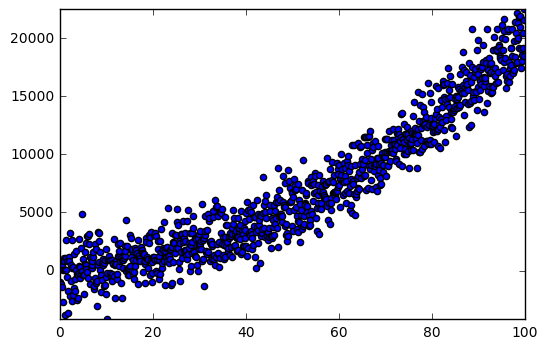

In [12]:
# First we create data
# x = np.arange(0,100,.1)
par = {'a':2,'b':4, 'c':-3} # parabola!
y_p = add_noise(np.array([
                par['a'] * i**2 + par['b'] * i + par['c']  
                for i in x]), 
              intensity=1500)

# Create a Figure object in which my plot will reside
fig = plt.figure()
polydata_graph = fig.add_subplot(1,1,1)

# Create a "subplot"
polydata_graph.scatter(x, y_p, c='b')
polydata_graph.axis([0,100,y_p.min(),y_p.max()])

fig.show()

I can attempt to fit this with a line, and then side-by-side plot the __residual plot__, that is the plot of $x_i$ versus $\widehat{y}_i - y_i$.  It's a very important thing to look at, because if you aren't seeing random noise, then that's an indicator that you haven't found a good model.

In [13]:
# Construct a regression model
linreg = LinearRegression()
linreg.fit(x.reshape(-1,1),y_p)

m_poly = linreg.coef_[0]
b_poly = linreg.intercept_
print("Slope:", m_poly, "Intercept:", b_poly)

Slope: 198.003080063 Intercept: -2956.52823242


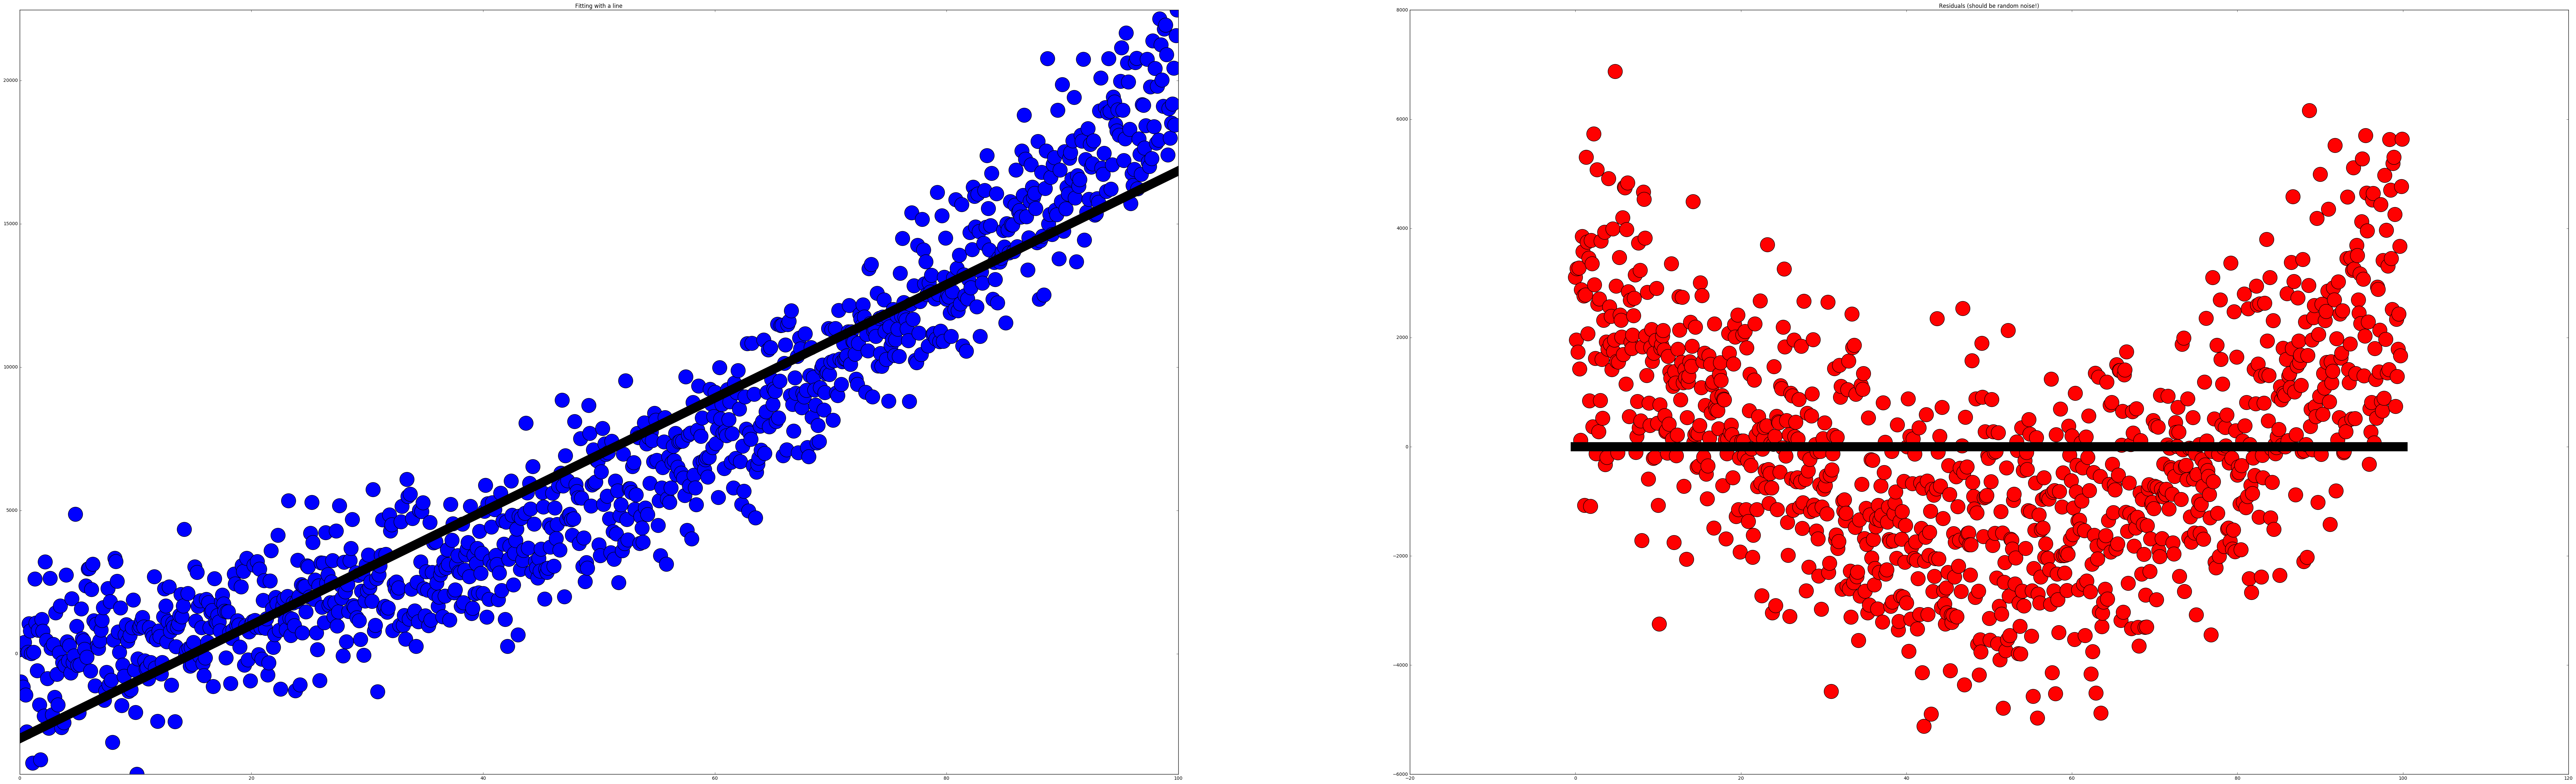

In [14]:
# don't ask.  :-/
weird_size = 1000
weird_thickness = 20

# Create a Figure and subplot objects
fig = plt.figure(figsize=(100,30))
polydata_graph = fig.add_subplot(1,2,1)
residuals = fig.add_subplot(1,2,2)

# Plot the data and the best fit line
polydata_graph.scatter(x, y_p, c='b', s=weird_size)
polydata_graph.axis([0,100,y_p.min(),y_p.max()])
polydata_graph.plot([0,100],[b_poly, b_poly + 100 * m_poly], c='k', linewidth=weird_thickness)
polydata_graph.set_title("Fitting with a line") # "Dr Z, where's your title?"

# Create residuals array
resid = y_p - np.array([b_poly + i * m_poly for i in x])

# Plot the residuals
residuals.scatter(x, resid, c='r', s=weird_size)
residuals.plot([0,100],[0,0], c='k', linewidth=weird_thickness)
# residuals.plot()
residuals.set_title("Residuals (should be random noise!)") # "I thought I told you not to ask!"

plt.show()

# Again, if you don't get anything from this plot, then you're in %matplotlib notebook mode already

In statistical lingo, what we see here is that there is correlation between the residuals and $x$. If you go to a certain $x$ value, you have a better-than-$50\%$ chance of guessing whether the residual there is positive or negative.  There's also autocorrelation with the residuals: if you know where one residual is, you have a better-than-$50\%$ chance of guessing where its neighbors are. The take away is:

## You have not fit the data with your model!

Great, okay, but how could we possibly fit a line to polynomial data?  The answer is so extremely awesome that it receives the coolest of all math words to describe it.  It's called the _kernel trick_, and it goes like this:

## Nobody said you had to fit a 1-DIMENSIONAL line to your data

"Wait. That doesn't make any sense, Dr. Z".  I know what you mean, we've got 1-dimensional data here: it's just $x$, and it's supposed to predict $y$.  By "1-dimensional data", I'm referring to the dimension of the predictors.

Let's change that.

In [15]:
df = pd.DataFrame(x, columns = ['x'])
print(df.shape, " <-- See, 1-dimensional!")

df.head(5)

(1000, 1)  <-- See, 1-dimensional!


,x
0,0.0
1,0.1
2,0.2
3,0.3
4,0.4


Okay, yeah, one dimension.  Got it.  Since we can look at the picture and it looks like a parabola, we want to create a new axis, call it $w$.  For its data, we will set $w = x^2$. Normally, figuring out what to make it is tough.  You may need to make some crazy function of multiple previous columns.  Who knows!  That's what makes this tough.

In [16]:
df['w (or rather, x^2)'] = df['x']**2
df.head()

,x,"w (or rather, x^2)"
0,0.0,0.00
1,0.1,0.01
2,0.2,0.04
3,0.3,0.09
4,0.4,0.16


In order to see what we're doing graphically, we need some more magic.

### New Jupyter Magic

This "Jupyter magic" will still create plots inline with the notebook, but it will give the plots some very basic interactivity.  I typically only use it if I will need it, because it tends to get in my way when scrolling around the notebook or changing plots.  It somewhat messes with the plots when you use the "shorthand way" of constructing plots 

In [17]:
# Note: after running this cell, you'll be in "Notebook mode" 
# until you run the top cell again.  Don't forget about kernel
# linearity!

%matplotlib notebook

The visuals were hanging my computer for some reason, so I downsample the x's, w's, and y's:

In [18]:
down_df = df[::10]
down_y_p = y_p[::10]

print(down_df.shape, down_y_p.shape)
down_df.head()

(100, 2) (100,)


,x,"w (or rather, x^2)"
0,0.0,0.0
10,1.0,1.0
20,2.0,4.0
30,3.0,9.0
40,4.0,16.0


Now take a look at what we've created with this new dataset:

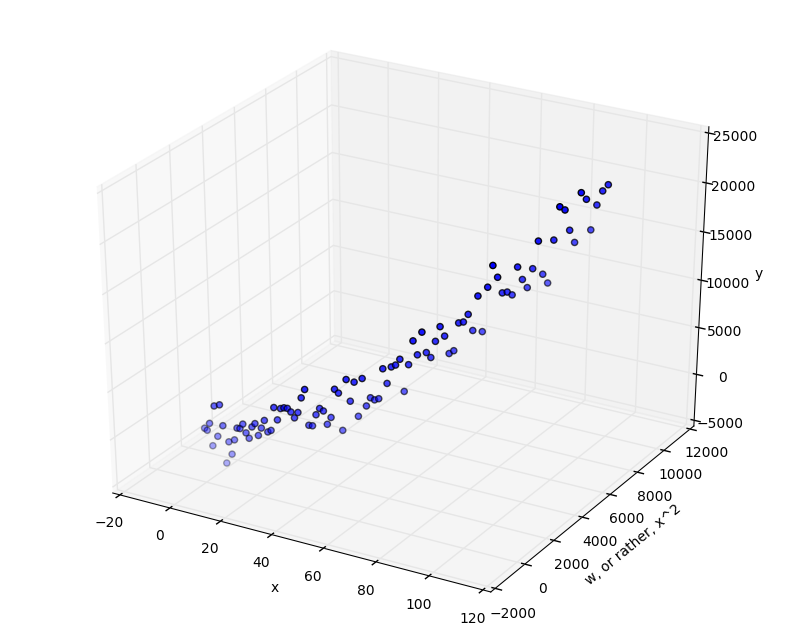

In [22]:
fig = plt.figure(figsize=(10,8))
scatter_3d = fig.add_subplot(111, projection='3d')

scatter_3d.scatter(down_df['x'], down_df['w (or rather, x^2)'], down_y_p)

scatter_3d.set_xlabel('x')
scatter_3d.set_ylabel('w, or rather, x^2')
scatter_3d.set_zlabel('y')

plt.show()

Now, we fit a plane to this dataset:

In [23]:
planereg = LinearRegression()
planereg.fit(df.values, y_p) #df.values is the numpy array underlying the pandas dataframe

# model parameters
m_x, m_w = planereg.coef_
b = planereg.intercept_
print("x-\"slope\":", m_x, ", w-\"slope\":", m_w, ", intercept: ", b)

x-"slope": 5.85030209993 , w-"slope": 1.92345123086 , intercept:  239.612974364


Next, we plot the plane we've fit:

In [24]:
# Generate a mesh
x_plane = np.arange(0, 100, 1)                
w_plane = np.arange(0, 10000, 100)
x_plane, w_plane = np.meshgrid(x_plane, w_plane)

# Construct the plane's y-values
y_plane = m_x * x_plane + m_w * w_plane + b

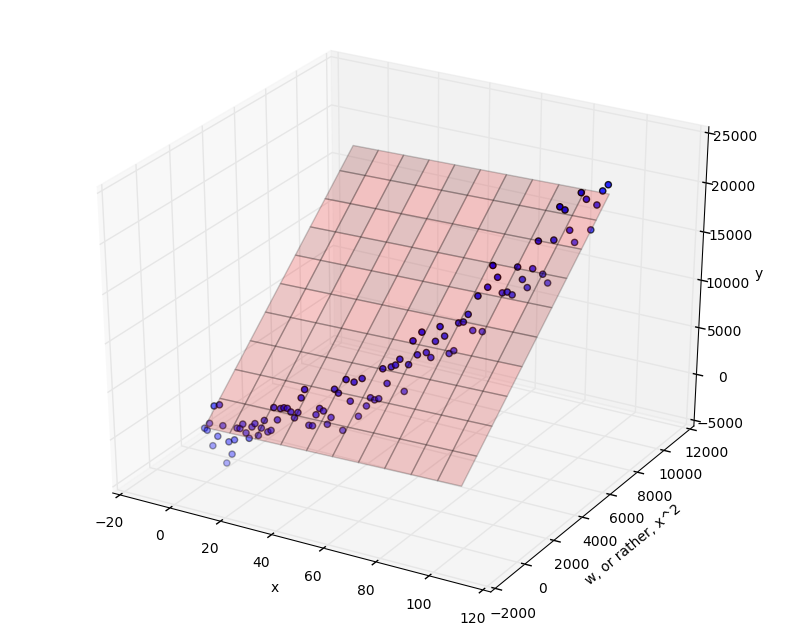

In [26]:
fig = plt.figure(figsize=(10,8))
scatter_3d = fig.add_subplot(1,1,1, projection='3d')

scatter_3d.set_xlabel('x')
scatter_3d.set_ylabel('w, or rather, x^2')
scatter_3d.set_zlabel('y')

# Plot the data
scatter_3d.scatter(down_df['x'], down_df['w (or rather, x^2)'], down_y_p)

# Plot the plane
scatter_3d.plot_surface(x_plane, w_plane, y_plane, color='r', alpha=.2)

plt.show()

Amazing!  We did fit a "line" of _some_ dimension to the data.  To finish off, we just "remember" that $w$ is really $x^2$.  This is really just projecting back to the $xy$-plane:

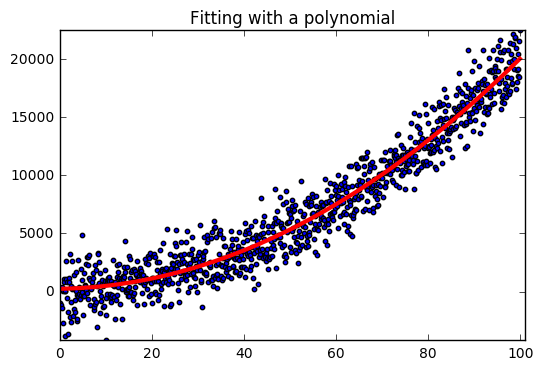

In [27]:
# To graph curves, you need to create a fine-mesh line plot:
y_parabola = m_w * x**2 + m_x * x + b

# Create a Figure and subplot objects
fig = plt.figure()
polydata_graph = fig.add_subplot(1,1,1)

# Plot the data and the best fit line
polydata_graph.scatter(x, y_p, c='b', s=10)
polydata_graph.axis([0,101,y_p.min(),y_p.max()])
polydata_graph.plot(x, y_parabola, c='r', linewidth=3)
polydata_graph.set_title("Fitting with a polynomial")

plt.show()

You might want to ask: "where did you get that equation, $m_w x^2 + m_x x + b = y$?"  That's a great question, imaginary student!  Well, the answer lies in figuring out what is meant mathematically by the statment: "_remember_ that $w$ is really just $x^2$".  There's an equation we have that performs this "remembering":  it's the equation of the surface 
$$x^2 = w$$
The actual equation we get is the one that comes from creating a __system of equations__:
\begin{align}
w &= x^2, \\
y &= m_w w + m_x x + b 
\end{align}

This surface appears as follows in $xwy$-space, the parabola we fit is the bright red spacecurve in the figure, projected to the $xy$-axis.

In [28]:
# First: generate a mesh for the surface
x_s = np.arange(0, 100, 1)                
y_s = np.arange(y_p.min(), y_p.max(), (y_p.max() - y_p.min())/1000)
x_s, y_s = np.meshgrid(x_s, y_s)

w_s = x_s**2

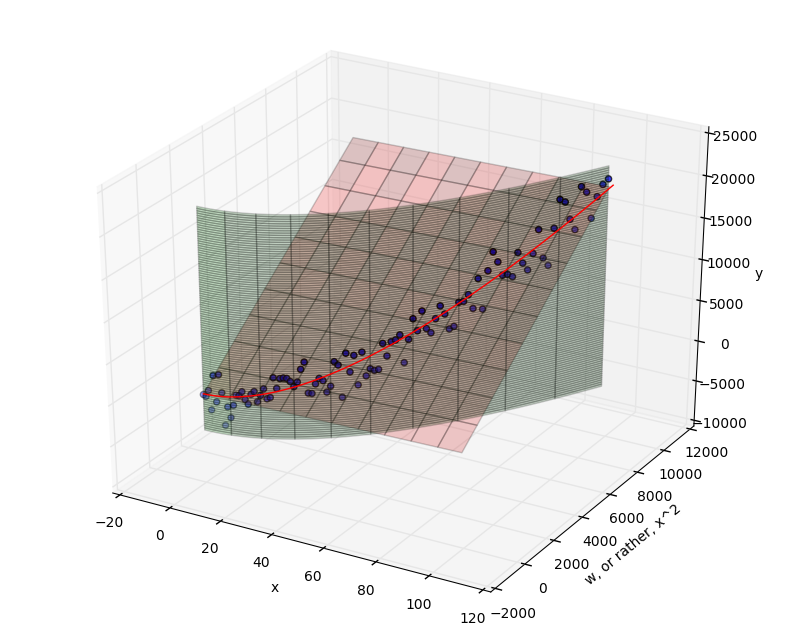

In [29]:
fig = plt.figure(figsize=(10,8))
scatter_3d = fig.add_subplot(1,1,1, projection='3d')

scatter_3d.set_xlabel('x')
scatter_3d.set_ylabel('w, or rather, x^2')
scatter_3d.set_zlabel('y')

# Plot the data
scatter_3d.scatter(down_df['x'], down_df['w (or rather, x^2)'], down_y_p)

# Plot the plane and surface
scatter_3d.plot_surface(x_plane, w_plane, y_plane, color='r', alpha=.2)
scatter_3d.plot_surface(x_s, w_s, y_s, color='g', alpha=.2)

# Plot the line of intersection 
scatter_3d.plot(x, x**2, y_parabola, color='r')

plt.show()

The last thing you always want to do when you create a mode is to graph the residuals:

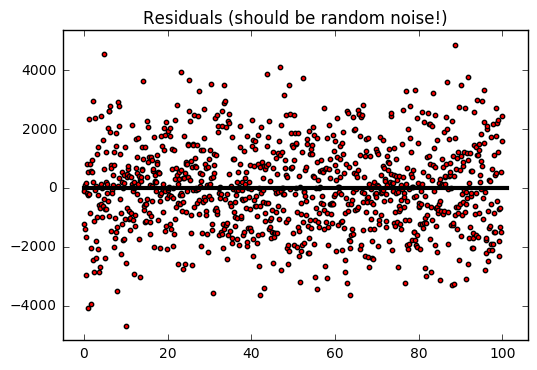

In [30]:
# Create residuals array
fig = plt.figure()
residuals = fig.add_subplot(1,1,1)

resid = y_p - np.array([m_w* i**2 + m_x * i + b  for i in x])

# Plot the residuals
residuals.scatter(x, resid, c='r', s=10)
residuals.plot([0,101],[0,0], c='k', linewidth=3)
residuals.set_title("Residuals (should be random noise!)")
# residuals.set_axis([0, 101, resid.min() - 10, resid.max + 10])
residuals.autoscale(tight=True)

Sweet, sweet randomness. 

## Final remark: the Student's t-Test

You may be wondering if there is a way to get some hard numbers around this idea of "Are my residuals actually random?"  The answer is yes, absolutely.  That's one of the main points of Statistics!  The one you're looking for is called the [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test), and we may or may not get into it.